In [26]:
import numpy as np
import numba
from numba import cuda
from time import time
import matplotlib.pyplot as plt
import warnings
from PIL import Image
import math
warnings.filterwarnings('ignore')

**Расширение и сужение массива на необходимое количество строк и столбцов в зависимости от размера окна (дублирование/обрезание крайних)**

In [2]:
def extend_array(a, sizew):
  t=(int)(sizew/2)
  for _ in range(t):
    a = np.hstack((a[:,0].reshape(-1,1), a, a[:, len(a[0])-1].reshape(-1, 1)))
    a = np.vstack((a[0][:], a, a[len(a)-1][:]))
  return a

def cut_array(a, sizew):
  t=(int)(sizew/2)
  l=[]
  for i in range(t, a.shape[0]-t):
    l.append(a[i,t:-t])
  return np.array(l)

**Реализация алгоритма на cpu**

In [3]:
# реализация алгоритма на cpu
def harris_cpu(im, sizew):
  #для отклика
  mark = np.zeros((im.shape[0], im.shape[1]), dtype=np.float64)
  start = time()
  #смещение
  t = (int)(sizew/2)

  for i in range(t+1, im.shape[0]-t-1):
    for j in range(t+1, im.shape[1]-t-1):
      # корр матрица
      m=np.zeros((2,2), dtype=np.float64)
      # считается как взвешенная сумма разностей
      for k in range (-t, t+1):
          for l in range(-t, t+1):
            #гауссиана
            g = 1./2/math.pi*math.e**(-(k**2+l**2)/2.)
            #производные по х и у рассчитанные с помощью оператора собеля
            Ix = im[i-1+k][j-1+l]*-1 + im[i-1+k][j+1+l]*1 + im[i+k][j-1+l]*-2 + im[i+k][j+1+l]*2 + im[i+1+k][j-1+l]*-1 + im[i+1+k][j+1+l]*1
            Iy = im[i-1+k][j-1+l]*-1 + im[i-1+k][j+l]*-2 + im[i-1+k][j+1+l]*-1 + im[i+1+k][j-1+l]*1 + im[i+1+k][j+l]*2 + im[i+1+k][j+1+l]*1
            m[0][0] += (Ix**2 * g)
            m[1][1] += (Iy**2 * g)
            m[0][1] += (Ix*Iy * g)
            m[1][0] += (Ix*Iy * g)
      # определитель и след корр матрицы
      detA = m[0][0]*m[1][1] - m[0][1]*m[1][0]
      traceA = m[0][0]+m[1][1] 
      # Отклик на смещение
      mark[i][j] = detA - 0.05*traceA**2
  return mark, time()-start

**Реализация алгоритма на gpu и функция подготовки параметров**

In [111]:
# import numba
# from numba import cuda

@cuda.jit
def harris_gpu(im, sizew, mark_d, w, h):
  t = (int)(sizew[0]/2)
  i, j = cuda.grid(2)
  if i>t and j>t and i<w[0]-t and j<h[0]-t:
    m=cuda.local.array((2,2), dtype=numba.float64)
    # m=np.zeros((2,2), dtype=np.float64)
    for k in range (-t, t+1):
      for l in range(-t, t+1):
        #гауссиана
        g = 1./2/math.pi*math.e**(-(k**2+l**2)/2.)
        #производные по х и у рассчитанные с помощью оператора собеля
        Ix = im[i-1+k][j-1+l]*-1 + im[i-1+k][j+1+l]*1 + im[i+k][j-1+l]*-2 + im[i+k][j+1+l]*2 + im[i+1+k][j-1+l]*-1 + im[i+1+k][j+1+l]*1
        Iy = im[i-1+k][j-1+l]*-1 + im[i-1+k][j+l]*-2 + im[i-1+k][j+1+l]*-1 + im[i+1+k][j-1+l]*1 + im[i+1+k][j+l]*2 + im[i+1+k][j+1+l]*1
        m[0][0] += (Ix**2 * g)
        m[1][1] += (Iy**2 * g)
        m[0][1] += (Ix*Iy * g)
        m[1][0] += (Ix*Iy * g)
    # определитель и след корр матрицы
    detA = m[0][0]*m[1][1] - m[0][1]*m[1][0]
    traceA = m[0][0]+m[1][1] 
    # Отклик на смещение
    mark_d[i][j] = detA - 0.05*traceA**2

def prepare_and_exec_gpu(im, sizew):
  w = im.shape[0]
  h = im.shape[1]
  mark = np.zeros((w, h), dtype=np.float64)

  im_d = cuda.to_device(im)
  mark_d = cuda.to_device(mark)
  w_d = cuda.to_device(w)
  h_d = cuda.to_device(h)
  sizew_d = cuda.to_device(sizew)

  # задаем сетку
  blok = (8,8)
  grid = (int(math.ceil(w/blok[0])), int(math.ceil(h/blok[1])))

  start = time()
  harris_gpu[grid, blok](im_d, sizew_d, mark_d, w_d, h_d)
  end = time()-start

  mark = mark_d.copy_to_host()
  return mark, end

**Отрисовка точек углов**

In [117]:
def draw_angle(a, mark, sizew):
  sc = (int)(sizew/2)
  for i in range(sc, mark.shape[0]-sc):
    for j in range(sc, mark.shape[1]-sc):
      # определяем локальные максимумы и перекрашиваем подходящие пикселы в красный цвет
      if mark[i][j]>0:
        t = mark[i][j]
        f = True
        for k in range(-sc, sc+1):
          for l in range(-sc, sc+1):
            if k!=l:
              if mark[i+k][j+l] > t:
                f=False
        if f:
          a[i-sc][j-sc] = [255,0,0]
  return a

**Функция одного замера**

In [155]:
def experiment(file_name, window_size, needDraw):
  im_src=(Image.open(file_name)).convert('RGB')
  im = im_src.convert('L')
  img_array = np.array(im)
  ex_im = extend_array(img_array, window_size)
  res_gpu, time_gpu = prepare_and_exec_gpu(ex_im, window_size)
  res_gpu_img = Image.fromarray(np.uint8(draw_angle(np.array(im_src), res_gpu, window_size)))

  res_cpu, time_cpu = harris_cpu(ex_im, window_size) 
  res_cpu_img = Image.fromarray(np.uint8(draw_angle(np.array(im_src), res_cpu, window_size)))

  if needDraw:
    print('исходное изображение')
    display(im_src.resize((500,500)))
    print('полученное на gpu')
    display(res_gpu_img.resize((500,500)))
    print('полученное на cpu')
    display(res_cpu_img.resize((500,500)))
  res_gpu_img.resize((500,500)).save('gpu_'+file_name)
  res_cpu_img.resize((500,500)).save('cpu_'+file_name)
  return time_gpu, time_cpu

In [156]:
def exec(name, needDraw):
  n = [3,5,7]
  c =[]
  g=[]
  a=[]
  for ni in n:
    gi, ci = experiment(name, ni, needDraw)
    c.append(ci)
    g.append(gi)
    a.append(ci/gi)

  plt.plot(np.array(n), np.array(a))
  plt.title('График зависимости ускорения от размера окна')
  plt.show()

  for i in range(len(n)):
    print('размер окна:',n[i],'; cpu:', c[i],'; gpu:', g[i],'; a:',a[i])

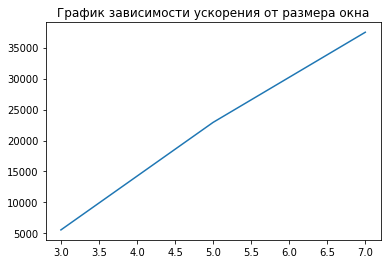

размер окна: 3 ; cpu: 3.387784481048584 ; gpu: 0.0006091594696044922 ; a: 5561.408219178083
размер окна: 5 ; cpu: 9.614546775817871 ; gpu: 0.00041937828063964844 ; a: 22925.71461057419
размер окна: 7 ; cpu: 18.810707569122314 ; gpu: 0.0005018711090087891 ; a: 37481.15249406176


In [157]:
exec('out.jpg', False)

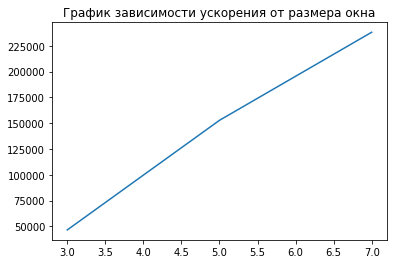

размер окна: 3 ; cpu: 25.138672351837158 ; gpu: 0.0005395412445068359 ; a: 46592.67962881131
размер окна: 5 ; cpu: 67.11236095428467 ; gpu: 0.0004391670227050781 ; a: 152817.39630836048
размер окна: 7 ; cpu: 130.7240345478058 ; gpu: 0.0005488395690917969 ; a: 238182.59817549956


In [158]:
exec('1.jpg', False)

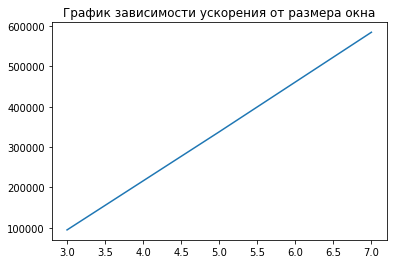

размер окна: 3 ; cpu: 54.66663718223572 ; gpu: 0.0005764961242675781 ; a: 94825.68031430934
размер окна: 5 ; cpu: 147.94321513175964 ; gpu: 0.0004379749298095703 ; a: 337789.2318998367
размер окна: 7 ; cpu: 288.00311851501465 ; gpu: 0.0004928112030029297 ; a: 584408.6269956458


In [159]:
exec('harris_img.png', False)